In [45]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [46]:
df =pd.read_sql_table('cloud', 'sqlite:///dissertation.db') 

In [47]:
df_copy = df.copy()

In [48]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,89.5,-1,0,0,0,weekday,0.000249
1,2019-12-23 00:00:10,88.0,-1,0,0,0,weekday,0.000244
2,2019-12-23 00:00:20,88.5,-1,0,0,0,weekday,0.000246
3,2019-12-23 00:00:30,88.5,-1,0,0,0,weekday,0.000246
4,2019-12-23 00:00:40,88.5,-1,0,0,0,weekday,0.000246
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,133.0,23,6,23,59,holiday,0.000369
1451516,2020-06-07 23:59:20,133.0,23,6,23,59,holiday,0.000369
1451517,2020-06-07 23:59:30,136.0,23,6,23,59,holiday,0.000378
1451518,2020-06-07 23:59:40,133.5,23,6,23,59,holiday,0.000371


In [49]:

# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})


In [41]:
df_half

,Half_Wh
time,
2019-12-23 00:00:00,44.387500
2019-12-23 00:30:00,44.506944
2019-12-23 01:00:00,44.395833
2019-12-23 01:30:00,44.356944
2019-12-23 02:00:00,44.329167
...,...
2020-06-07 21:30:00,66.773611
2020-06-07 22:00:00,66.802778
2020-06-07 22:30:00,66.730556


In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [11]:
# subset 80% of dataset for train and test, 20% for future input  
subset = 6451
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [12]:
# split into train and test sets
train_size = int(len(train_test) * 0.75)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

4838 1613


In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
look_back=1
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [15]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=1, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])
history=model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 2s - loss: 22.7806 - mse: 22.7806 - mae: 1.2739
Epoch 2/200
 - 2s - loss: 0.1254 - mse: 0.1254 - mae: 0.1133
Epoch 3/200
 - 2s - loss: 0.1350 - mse: 0.1350 - mae: 0.1315
Epoch 4/200
 - 2s - loss: 0.1423 - mse: 0.1423 - mae: 0.1364
Epoch 5/200
 - 2s - loss: 0.1398 - mse: 0.1398 - mae: 0.1310
Epoch 6/200
 - 2s - loss: 0.1377 - mse: 0.1377 - mae: 0.1290
Epoch 7/200
 - 2s - loss: 0.1417 - mse: 0.1417 - mae: 0.1320
Epoch 8/200
 - 2s - loss: 0.1419 - mse: 0.1419 - mae: 0.1297
Epoch 9/200
 - 2s - loss: 0.1418 - mse: 0.1418 - mae: 0.1329
Epoch 10/200
 - 2s - loss: 0.1410 - mse: 0.1410 - mae: 0.1261
Epoch 11/200
 - 2s - loss: 0.1420 - mse: 0.1420 - mae: 0.1301
Epoch 12/200
 - 2s - loss: 0.1412 - mse: 0.1412 - mae: 0.1269
Epoch 13/200
 - 2s - loss: 0.1410 - mse: 0.1410 - mae: 0.1286
Epoch 14/200
 - 2s - loss: 0.1401 - mse: 0.1401 - mae: 0.1277
Epoch 15/200
 - 2s - loss: 0.1414 - mse: 0.1414 - mae: 0.1315
Epoch 16/200
 - 2s - loss: 0.1372 - mse: 0.1372 - mae: 0.1272
Epoch 17/200
 -

Epoch 133/200
 - 2s - loss: 0.1328 - mse: 0.1328 - mae: 0.1158
Epoch 134/200
 - 2s - loss: 0.1366 - mse: 0.1366 - mae: 0.1243
Epoch 135/200
 - 2s - loss: 0.1340 - mse: 0.1340 - mae: 0.1209
Epoch 136/200
 - 2s - loss: 0.1372 - mse: 0.1372 - mae: 0.1234
Epoch 137/200
 - 2s - loss: 0.1383 - mse: 0.1383 - mae: 0.1244
Epoch 138/200
 - 2s - loss: 0.1392 - mse: 0.1392 - mae: 0.1234
Epoch 139/200
 - 2s - loss: 0.1343 - mse: 0.1343 - mae: 0.1147
Epoch 140/200
 - 2s - loss: 0.1393 - mse: 0.1393 - mae: 0.1256
Epoch 141/200
 - 2s - loss: 0.1363 - mse: 0.1363 - mae: 0.1224
Epoch 142/200
 - 2s - loss: 0.1347 - mse: 0.1347 - mae: 0.1193
Epoch 143/200
 - 2s - loss: 0.1375 - mse: 0.1375 - mae: 0.1239
Epoch 144/200
 - 2s - loss: 0.1330 - mse: 0.1330 - mae: 0.1159
Epoch 145/200
 - 2s - loss: 0.1376 - mse: 0.1376 - mae: 0.1213
Epoch 146/200
 - 2s - loss: 0.1364 - mse: 0.1364 - mae: 0.1234
Epoch 147/200
 - 2s - loss: 0.1356 - mse: 0.1356 - mae: 0.1221
Epoch 148/200
 - 2s - loss: 0.1321 - mse: 0.1321 - mae:

In [16]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])


1611/1611 [==============================] - 0s 19us/step
Train MSE:  0.11567757278680801 MAE:  0.06672994047403336
Test MSE:  0.008929312229156494 MAE:  0.05419446900486946


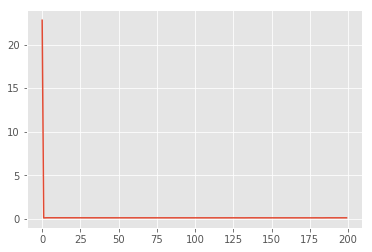

In [17]:
plt.plot(history.history['loss'])

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [19]:
print(nextPredict,df_simu[0:1].values)

[[66.14631]] [[66.24166667]]


In [20]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.9969273249938094

In [21]:
time = np.arange('2019-12-23 00:00:00','2020-06-08 00:00:00', dtype='datetime64[30m]')

In [22]:
dates = list(time)
#plt.pyplot.plot_date(dates, values)

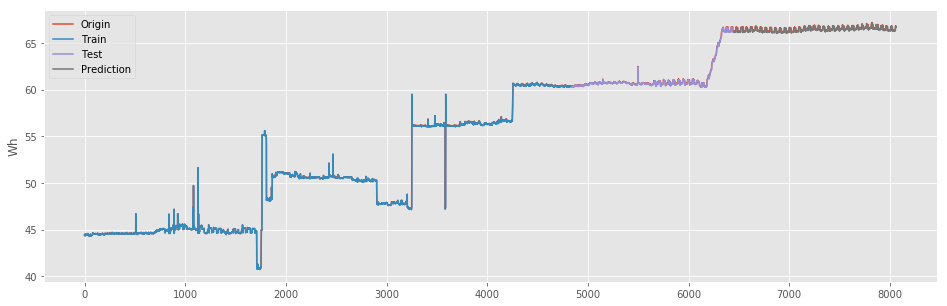

In [23]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [24]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)


Text(0, 0.5, 'Wh')

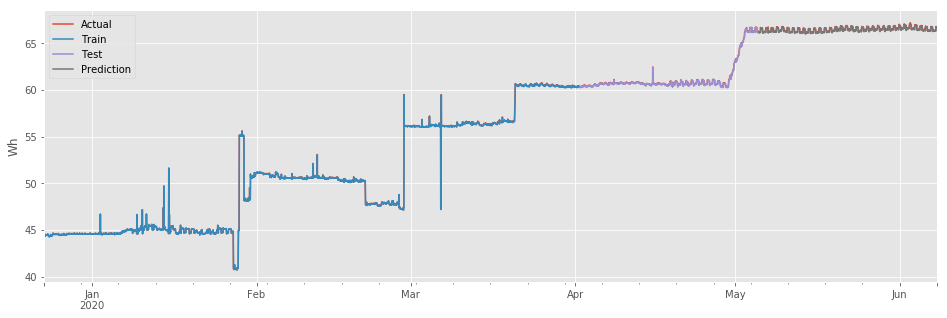

In [25]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

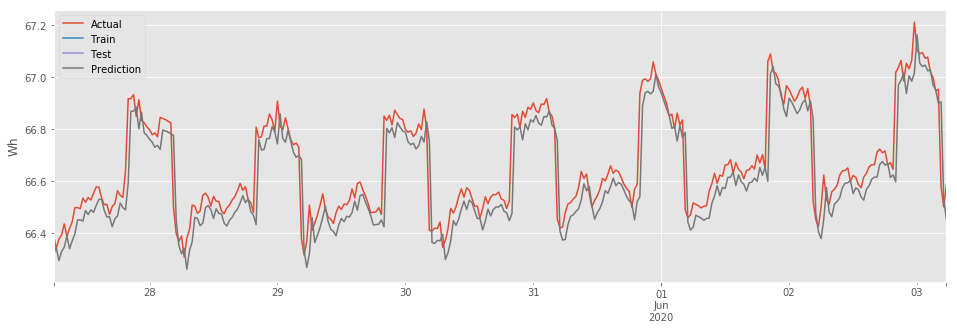

In [26]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

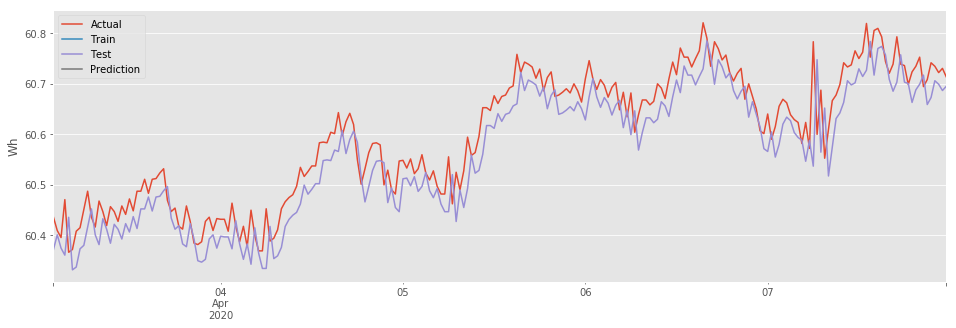

In [33]:
df_all_plot[4900:5136].set_index(df_all_plot[4900:5136].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

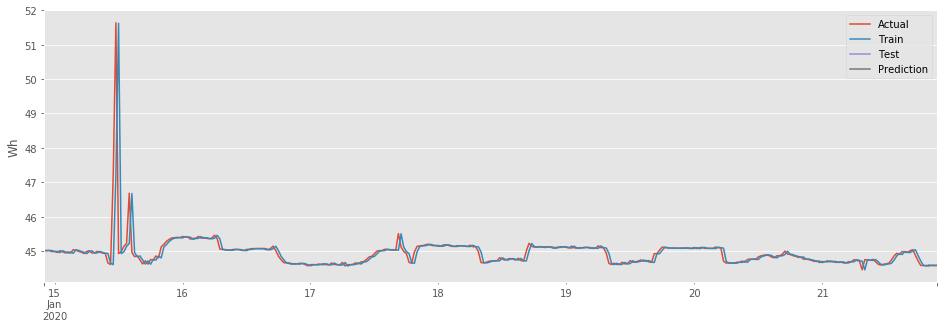

In [34]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [35]:
# save the model 
model.save('cloud_ann.h5')

In [50]:
# with lockdown
mad_mean_ratio =0.054*1613/df_half['Half_Wh'][6451-1613:6451].sum() 
mad_mean_ratio

0.0008800730959946352